In [1]:
%matplotlib inline
import time

# python 3
import urllib.error
from urllib.request import urlopen
import datetime
#from itertools import ifilter
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET

from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import bibtexparser

pd.set_option('mode.chained_assignment','warn')

In [25]:
OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

def harvest(arxiv="physics:astro-ph", from_date="2016-08-01", until_date="2016-08-31"):
    """
    input: arxiv is the "set" defined in http://export.arxiv.org/oai2?verb=ListSets
    """
    df = pd.DataFrame(columns=("title", "abstract", "categories", "created", "id", "doi"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords"
    url = (base_url +
           "&from=%s" % from_date +
           "&until=%s" % until_date + 
           "&metadataPrefix=arXiv&set=%s"%arxiv)
    
    while True:
        print("fetching", url)
        try:
            response = urlopen(url)
            
        except urllib.error.HTTPError as e:
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print("Got 503. Retrying after {0:d} seconds.".format(to))

                time.sleep(to)
                continue
                
            else:
                raise
            
        xml = response.read()

        root = ET.fromstring(xml)

        for record in root.find(OAI+'ListRecords').findall(OAI+"record"):
            arxiv_id = record.find(OAI+'header').find(OAI+'identifier')
            meta = record.find(OAI+'metadata')
            info = meta.find(ARXIV+"arXiv")
            created = info.find(ARXIV+"created").text
            created = datetime.datetime.strptime(created, "%Y-%m-%d")
            categories = info.find(ARXIV+"categories").text

            # if there is more than one DOI use the first one
            # often the second one (if it exists at all) refers
            # to an eratum or similar
            doi = info.find(ARXIV+"doi")
            if doi is not None:
                doi = doi.text.split()[0]
                
            contents = {'title': info.find(ARXIV+"title").text,
                        'id': info.find(ARXIV+"id").text,#arxiv_id.text[4:],
                        'abstract': info.find(ARXIV+"abstract").text.strip(),
                        'created': created,
                        'categories': categories.split(),
                        'doi': doi,
                        }

            df = df.append(contents, ignore_index=True)

        # The list of articles returned by the API comes in chunks of
        # 1000 articles. The presence of a resumptionToken tells us that
        # there is more to be fetched.
        token = root.find(OAI+'ListRecords').find(OAI+"resumptionToken")
        if token is None or token.text is None:
            break

        else:
            url = base_url + "&resumptionToken=%s"%(token.text)
            
    return df
    

In [26]:
df = harvest(arxiv="physics:astro-ph")

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2016-08-01&until=2016-08-31&metadataPrefix=arXiv&set=physics:astro-ph
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=2128582|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=2128582|2001
Got 503. Retrying after 10 seconds.
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=2128582|2001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=2128582|3001
Got 503. Retrying after 10 seconds.
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=2128582|3001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=2128582|4001
Got 503. Retrying after 10 seconds.
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=2128582|4001


In [27]:
store = pd.HDFStore("astroph_Aug2016.h5")

In [28]:
store['df'] = df
#df = store['df']

/home/wklee/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['title', 'abstract', 'categories', 'id', 'doi']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
store.close()

In [23]:
ts = df['created'][0].to_pydatetime()

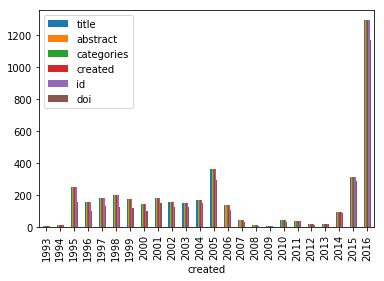

In [30]:
df.groupby(df["created"].dt.year).count().plot(kind="bar")

In [31]:
word_bag = " ".join(df.abstract.apply(lambda t: t.lower()))

Counter(word_bag.split()).most_common(n=10)

[('the', 62293),
 ('of', 34909),
 ('and', 19342),
 ('a', 16538),
 ('in', 15886),
 ('to', 14056),
 ('we', 10847),
 ('is', 9308),
 ('with', 8613),
 ('for', 7752)]

In [35]:
from nltk.corpus import stopwords

stops = [word for word in stopwords.words('english')]
stops += ["=", "->"]
#words = filter(lambda w: w not in stops,
#               word_bag.split())
words = [word for word in word_bag.split() if word not in stops]
top_twenty = Counter(words).most_common(n=20)

In [36]:
top_twenty

[('mass', 1998),
 ('galaxies', 1771),
 ('observed', 1564),
 ('emission', 1533),
 ('using', 1517),
 ('stars', 1506),
 ('find', 1505),
 ('model', 1504),
 ('also', 1501),
 ('present', 1492),
 ('star', 1444),
 ('x-ray', 1413),
 ('show', 1412),
 ('data', 1387),
 ('two', 1380),
 ('observations', 1371),
 ('stellar', 1362),
 ('galaxy', 1312),
 ('results', 1257),
 ('energy', 1210)]

In [37]:
import nltk.stem as stem

porter = stem.PorterStemmer()
#for w in ("measurement", "measurements", "measured", "measure"):
#    print(w, "->", porter.stem(w))
for w in ("galaxy", "galaxies", "galactic"):
    print(w, "->", porter.stem(w))

galaxy -> galaxi
galaxies -> galaxi
galactic -> galact


In [38]:
#word_stems = map(lambda w: (porter.stem(w),w), words)
word_stems_list = [(porter.stem(w),w) for w in words ]
stem2words = defaultdict(set)
for stem1, word in word_stems_list:
    stem2words[stem1].add(word)

In [39]:
def bar_chart(items):
    """Make a bar chart showing the count associated with each key
    
    `items` is a list of (key, count) pairs.
    """
    width = 0.5
    ind = np.arange(len(items))
    lab = np.array([ k for k, v in items])
    val = np.array([ v for k, v in items])
    fig, ax = plt.subplots(figsize=(15,8))
    rects1 = ax.bar(ind, val, width, color='r')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(lab)
    fig.autofmt_xdate()
    plt.show()

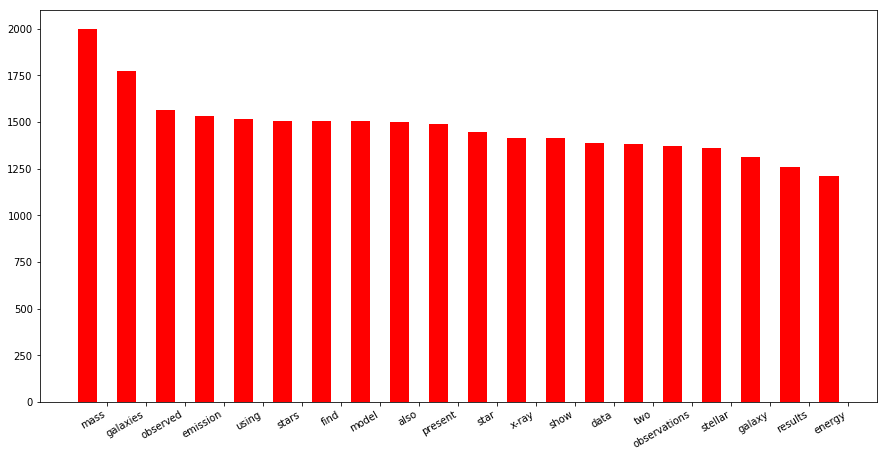

In [40]:
bar_chart(top_twenty)

In [41]:
new_top_twenty = Counter([s[0] for s in word_stems_list]).most_common(n=20)

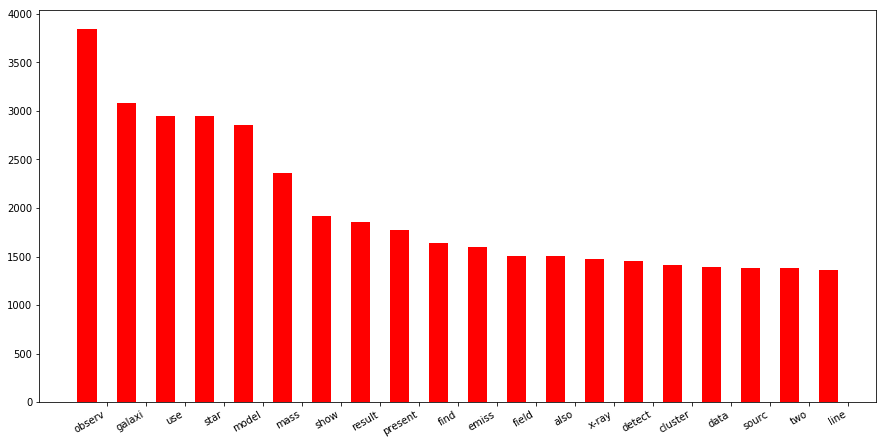

In [42]:
bar_chart(new_top_twenty)

In [43]:
stem2words['gravit']

{'gravitating',
 'gravitation',
 'gravitational',
 'gravitationally',
 'gravitional'}

In [49]:
stem2words['stellar']

{'stellar'}

In [103]:
[s[0] for s in word_stems_list]

['new',
 'photometr',
 'space-born',
 'survey',
 'mission',
 'corot',
 'kepler',
 'abl',
 'detect',
 'minut',
 'flux',
 'variat',
 'binari',
 'star',
 'due',
 'relativist',
 'beam',
 'caus',
 'line-of-sight',
 'motion',
 'components.',
 'short',
 'period',
 'binari',
 '(p>10d),',
 'variat',
 'domin',
 'ellipsoid',
 'reflect',
 'period',
 'variability.',
 'thus,',
 'corot',
 'kepler',
 'discov',
 'new',
 'observ',
 'class:',
 'photometr',
 'beam',
 'binari',
 'stars.',
 'examin',
 'new',
 'categori',
 'inform',
 'photometr',
 'variat',
 'provide.',
 'variat',
 'result',
 'observatori',
 'heliocentr',
 'veloc',
 'use',
 'extract',
 'spectral',
 'inform',
 'even',
 'singl',
 'stars.',
 'paper',
 'address',
 'problem',
 'scatter',
 'line',
 'polar',
 'hanl',
 'effect',
 'one-dimension',
 '(1d),',
 'two-dimension',
 '(2d)',
 'three-dimension',
 '(3d)',
 'media',
 'case',
 'two-level',
 'model',
 'atom',
 'without',
 'lower-level',
 'polar',
 'assum',
 'complet',
 'frequenc',
 'redistributio

In [33]:
import nltk

In [34]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True